In [343]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns


**Read in Files**

In [344]:
train_df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')

test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')


Set to understand the data

In [345]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


Merge the test and training data together

In [346]:
combined_df = pd.concat([train_df, test_df])

Fill all the null in RoomService/FoodCourt/ShoppingMall/Spa/VRDeck cost with 0

In [347]:
combined_df.fillna({'RoomService': 0, 'FoodCourt': 0, 'ShoppingMall': 0, 'Spa': 0, 'VRDeck': 0}, inplace=True)

Add up all the cost and create a new column call totalCost

In [348]:
combined_df['totalCost'] = combined_df['RoomService'] + combined_df['FoodCourt'] + combined_df['ShoppingMall'] + combined_df['Spa']+ combined_df['VRDeck']

After adding all of it up, drop those features

In [349]:
combined_df.drop(columns=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], inplace=True)

Add up all the cost by HomePlanet and find the mean

In [350]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12970 entries, 0 to 4276
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  12970 non-null  object 
 1   HomePlanet   12682 non-null  object 
 2   CryoSleep    12660 non-null  object 
 3   Cabin        12671 non-null  object 
 4   Destination  12696 non-null  object 
 5   Age          12700 non-null  float64
 6   VIP          12674 non-null  object 
 7   Name         12676 non-null  object 
 8   Transported  8693 non-null   object 
 9   totalCost    12970 non-null  float64
dtypes: float64(2), object(8)
memory usage: 1.1+ MB


In [351]:
earth_mean = combined_df.groupby('HomePlanet').get_group('Earth')['totalCost'].mean()
europa_mean = combined_df.groupby('HomePlanet').get_group('Europa')['totalCost'].mean()
mars_mean = combined_df.groupby('HomePlanet').get_group('Mars')['totalCost'].mean()

Plot those means out and it seems like **Europa people have high spending**

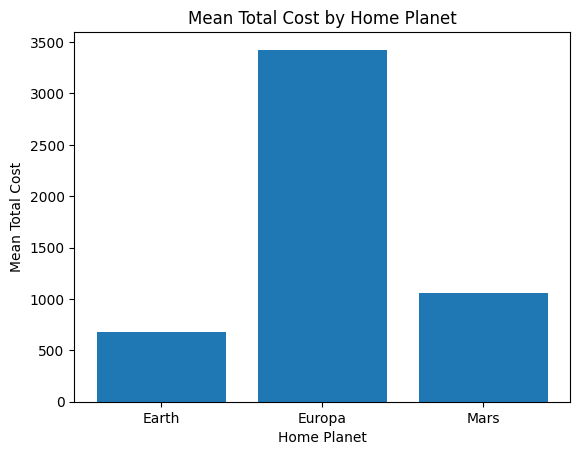

In [352]:
mean_values = [earth_mean, europa_mean, mars_mean]

# Create a list of the planet names
planet_names = ['Earth', 'Europa', 'Mars']

# Create the bar chart
plt.bar(planet_names, mean_values)

# Add a title and labels
plt.title('Mean Total Cost by Home Planet')
plt.xlabel('Home Planet')
plt.ylabel('Mean Total Cost')

# Show the plot
plt.show()

so fill in the HomePlanet if the user have high spending

In [353]:
combined_df['HomePlanet'] = np.where((combined_df['HomePlanet'].isnull()) & (combined_df['totalCost'] > 2000), 'Europa', combined_df['HomePlanet'])

Split the PassengerId into two section to find families

In [354]:
combined_df[['IDA', 'IDB']] = combined_df['PassengerId'].str.split('_', n=2, expand=True)

Also split the Cabin into Deck/Num/Side

In [355]:
combined_df[['Deck', 'Num', 'Side']] = combined_df['Cabin'].str.split('/', expand=True)

If they have the same IDA that means they are the same faimily and will be staying to gether in the same room

In [356]:
null_decks = combined_df[combined_df['Deck'].isnull()]
for index, row in null_decks.iterrows():
    ida = row['IDA']
    matching_row = combined_df[(combined_df['IDA'] == ida) & (combined_df['Deck'].notnull())]
    if not matching_row.empty:
        deck = matching_row['Deck'].values[0]
        num = matching_row['Num'].values[0]
        side = matching_row['Side'].values[0]
        combined_df.at[index, 'Deck'] = deck
        combined_df.at[index, 'Num'] = num
        combined_df.at[index, 'Side'] = side

Now drop cabin since we sperated them

In [357]:
combined_df.drop(columns=['Cabin'], inplace=True)

Seperate first name and last name because people from the same planet will have similar naming

In [358]:
combined_df[['FirstName', 'LastName']] = combined_df['Name'].str.split(' ', n=1, expand=True)

In [359]:
combined_df['FirstNameLength'] = combined_df['FirstName'].str.len()
combined_df['LastNameLength'] = combined_df['LastName'].str.len()

Check how long last names are from different planet

In [360]:
combined_df.loc[combined_df['HomePlanet'] == 'Mars', 'LastNameLength'].value_counts()

LastNameLength
5.0    1629
4.0     695
3.0     300
Name: count, dtype: int64

In [361]:
combined_df.loc[combined_df['HomePlanet'] == 'Earth', 'LastNameLength'].value_counts()

LastNameLength
10.0    1225
9.0     1207
7.0     1068
6.0     1028
8.0      873
11.0     792
5.0      513
Name: count, dtype: int64

If their lastname is longer than 5 characters then they are from Earth, other wise from Mars

In [362]:
combined_df['HomePlanet'] = np.where((combined_df['HomePlanet'].isnull()) & (combined_df['LastNameLength'] > 5), 'Earth', combined_df['HomePlanet'])
combined_df['HomePlanet'] = np.where((combined_df['HomePlanet'].isnull()) & (combined_df['LastNameLength'] <= 5), 'Mars', combined_df['HomePlanet'])

We can drop the name now since there's no use to it anymore

In [363]:
combined_df.drop(columns=['FirstName', 'LastName', 'FirstNameLength', 'LastNameLength','Name'], inplace=True)

Check if theres any correlation in Deck with different homeplanet

In [364]:
combined_df.loc[train_df['HomePlanet'] == 'Mars', 'Deck'].value_counts()

Deck
F    1404
E     419
D     347
G     265
C      70
B      69
A      20
T       1
Name: count, dtype: int64

In [365]:
combined_df.loc[train_df['HomePlanet'] == 'Europa', 'Deck'].value_counts()

Deck
B    869
C    835
F    365
G    316
A    280
D    237
E    226
T      4
Name: count, dtype: int64

In [366]:
combined_df.loc[train_df['HomePlanet'] == 'Earth', 'Deck'].value_counts()

Deck
G    3152
F    2387
E     648
C     204
B     203
D     137
A      53
T       5
Name: count, dtype: int64

People in Deck G are mostly from Earth and 

In [367]:
combined_df['HomePlanet'] = np.where((combined_df['HomePlanet'].isnull()) & (combined_df['Deck'] == 'G'), 'Earth', combined_df['HomePlanet'])

In [368]:
combined_df.loc[(combined_df['HomePlanet'] == 'Earth') & (combined_df['Deck'].isnull()), 'Deck'] = 'G'

In [369]:
combined_df.loc[(combined_df['HomePlanet'] == 'Mars') & (combined_df['Deck'].isnull()), 'Deck'] = 'F'

In [370]:
combined_df.loc[(combined_df['HomePlanet'] == 'Europa') & (combined_df['Deck'].isnull()), 'Deck'] = 'B'

In [371]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12970 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  12970 non-null  object 
 1   HomePlanet   12964 non-null  object 
 2   CryoSleep    12660 non-null  object 
 3   Destination  12696 non-null  object 
 4   Age          12700 non-null  float64
 5   VIP          12674 non-null  object 
 6   Transported  8693 non-null   object 
 7   totalCost    12970 non-null  float64
 8   IDA          12970 non-null  object 
 9   IDB          12970 non-null  object 
 10  Deck         12970 non-null  object 
 11  Num          12809 non-null  object 
 12  Side         12809 non-null  object 
dtypes: float64(2), object(11)
memory usage: 1.9+ MB


In [372]:
combined_df[combined_df['HomePlanet'].isnull()]

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,Transported,totalCost,IDA,IDB,Deck,Num,Side
2274,2443_01,NaN,False,TRAPPIST-1e,31.0,False,False,1955.0,2443,01,D,72,P
3091,3331_01,NaN,False,TRAPPIST-1e,40.0,False,True,803.0,3331,01,F,631,S
4548,4840_01,NaN,True,TRAPPIST-1e,36.0,False,True,0.0,4840,01,F,915,S
5762,6108_01,NaN,False,TRAPPIST-1e,13.0,False,False,864.0,6108,01,F,1166,S
2989,6559_03,NaN,False,TRAPPIST-1e,35.0,False,NaN,1139.0,6559,03,F,1252,S
3858,8435_01,NaN,NaN,TRAPPIST-1e,19.0,False,NaN,1389.0,8435,01,F,1730,P


In [373]:
combined_df.loc[(combined_df['Deck'] == 'F') & (combined_df['HomePlanet'].isnull()), 'HomePlanet'] = 'Earth'
combined_df.loc[(combined_df['Deck'] == 'D') & (combined_df['HomePlanet'].isnull()), 'HomePlanet'] = 'Mars'

When CryoSleep is True totalCost are most likely 0 

In [374]:

combined_df.loc[combined_df['CryoSleep']==True].head(30)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,Transported,totalCost,IDA,IDB,Deck,Num,Side
7,0006_02,Earth,True,TRAPPIST-1e,28.0,False,True,0.0,0006,02,G,0,S
9,0008_01,Europa,True,55 Cancri e,14.0,False,True,0.0,0008,01,B,1,P
10,0008_02,Europa,True,TRAPPIST-1e,34.0,False,True,0.0,0008,02,B,1,P
18,0016_01,Mars,True,TRAPPIST-1e,45.0,False,True,0.0,0016,01,B,0,S
21,0020_01,Earth,True,TRAPPIST-1e,1.0,False,False,0.0,0020,01,E,0,S
22,0020_02,Earth,True,55 Cancri e,49.0,False,False,0.0,0020,02,E,0,S
23,0020_03,Earth,True,55 Cancri e,29.0,False,False,0.0,0020,03,E,0,S
25,0020_05,Earth,True,PSO J318.5-22,1.0,False,False,0.0,0020,05,E,0,S
28,0024_01,Europa,True,TRAPPIST-1e,62.0,False,True,0.0,0024,01,C,2,S
36,0034_01,Europa,True,55 Cancri e,28.0,False,True,0.0,0034,01,D,1,S


In [375]:
combined_df.loc[(combined_df['totalCost'] == 0.0)&(combined_df['CryoSleep'].isnull()),'CryoSleep'] = True
combined_df.loc[(combined_df['totalCost'] > 0.0)&(combined_df['CryoSleep'].isnull()),'CryoSleep'] = False

In [376]:
combined_df.loc[combined_df['VIP']== True] 

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,Transported,totalCost,IDA,IDB,Deck,Num,Side
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,False,10383.0,0003,01,A,0,S
108,0112_01,Europa,False,55 Cancri e,48.0,True,True,2654.0,0112,01,B,1,S
120,0128_01,Mars,False,TRAPPIST-1e,61.0,True,False,3014.0,0128,01,D,3,S
214,0224_01,Mars,False,TRAPPIST-1e,32.0,True,False,1820.0,0224,01,F,42,S
291,0321_01,Mars,False,TRAPPIST-1e,59.0,True,False,1227.0,0321,01,F,61,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4092,8911_01,Mars,False,TRAPPIST-1e,43.0,True,NaN,1057.0,8911,01,D,279,P
4115,8936_01,Mars,False,TRAPPIST-1e,55.0,True,NaN,2151.0,8936,01,E,586,S
4133,8979_01,Mars,False,PSO J318.5-22,39.0,True,NaN,2005.0,8979,01,F,1738,S
4152,9016_03,Europa,False,55 Cancri e,30.0,True,NaN,20386.0,9016,03,B,345,S


In [377]:
VIP_mean = combined_df.groupby('VIP').get_group(True)['totalCost'].mean()
NoneVIP_mean = combined_df.groupby('VIP').get_group(False)['totalCost'].mean()

People in VIP spend more money

In [378]:
VIP_mean


4595.542124542125

In [379]:
NoneVIP_mean

1358.2765099588744

In [380]:
combined_df.loc[(combined_df['totalCost'] > 2500)&(combined_df['VIP'].isnull()),'VIP'] = True

In [381]:
combined_df.loc[(combined_df['totalCost'] <= 2500)&(combined_df['VIP'].isnull()),'VIP'] = False

In [382]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12970 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  12970 non-null  object 
 1   HomePlanet   12970 non-null  object 
 2   CryoSleep    12970 non-null  object 
 3   Destination  12696 non-null  object 
 4   Age          12700 non-null  float64
 5   VIP          12970 non-null  object 
 6   Transported  8693 non-null   object 
 7   totalCost    12970 non-null  float64
 8   IDA          12970 non-null  object 
 9   IDB          12970 non-null  object 
 10  Deck         12970 non-null  object 
 11  Num          12809 non-null  object 
 12  Side         12809 non-null  object 
dtypes: float64(2), object(11)
memory usage: 1.9+ MB


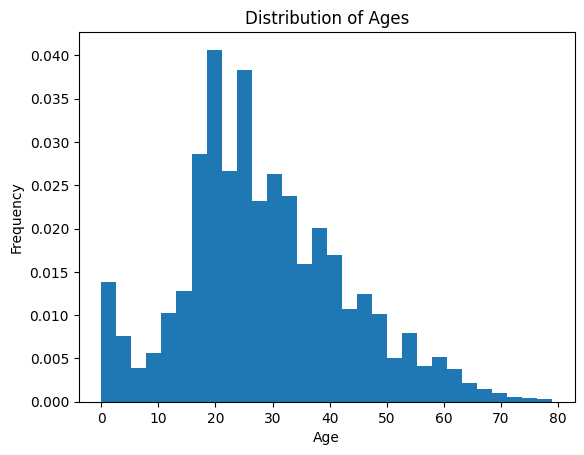

In [383]:
plt.hist(combined_df['Age'], bins=30, density=True)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Ages')
plt.show()

In [384]:
earth_mean = combined_df.groupby('HomePlanet').get_group('Earth')['Age'].mean()
europa_mean = combined_df.groupby('HomePlanet').get_group('Europa')['Age'].mean()
mars_mean = combined_df.groupby('HomePlanet').get_group('Mars')['Age'].mean()

In [385]:
combined_df.loc[(combined_df['HomePlanet'] == 'Earth')&(combined_df['Age'].isnull()),'Age'] = earth_mean
combined_df.loc[(combined_df['HomePlanet'] == 'Europa')&(combined_df['Age'].isnull()),'Age'] = europa_mean
combined_df.loc[(combined_df['HomePlanet'] == 'Mars')&(combined_df['Age'].isnull()),'Age'] = mars_mean




In [386]:
destination_counts = combined_df['Destination'].value_counts()
print(destination_counts)

Destination
TRAPPIST-1e      8871
55 Cancri e      2641
PSO J318.5-22    1184
Name: count, dtype: int64


most of the people from earth are going to TRAPPIST

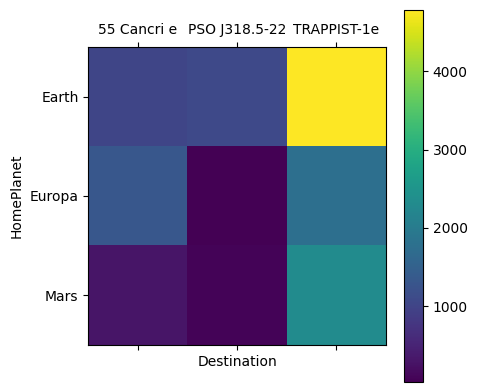

In [387]:

matrix = pd.crosstab(combined_df['HomePlanet'], combined_df['Destination'])
plt.matshow(matrix, fignum=1)
plt.colorbar()
plt.xlabel('Destination')
plt.ylabel('HomePlanet')

# Add category labels
plt.xticks(range(len(matrix.columns)), matrix.columns)
plt.yticks(range(len(matrix.index)), matrix.index)

plt.show()

In [388]:
mode_destination = combined_df['Destination'].mode().iloc[0]
combined_df['Destination'] = combined_df['Destination'].fillna(mode_destination)

In [389]:
Numcount = combined_df['Num'].value_counts()
Numcount

Num
82      34
56      28
230     27
31      27
0       27
        ..
1850     1
1851     1
1852     1
1859     1
1860     1
Name: count, Length: 1894, dtype: int64

In [390]:
combined_df.drop(columns = ['Num','Side','PassengerId'], inplace=True)


Add data are clean now, use OneHot or Ordinal Encoder

In [391]:
from sklearn.preprocessing import OneHotEncoder


In [392]:
ohe = OneHotEncoder(handle_unknown = 'ignore',sparse_output = False). set_output(transform = 'pandas')


Figure which one need to be OneHot

In [393]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12970 entries, 0 to 4276
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   HomePlanet   12970 non-null  object 
 1   CryoSleep    12970 non-null  object 
 2   Destination  12970 non-null  object 
 3   Age          12970 non-null  float64
 4   VIP          12970 non-null  object 
 5   Transported  8693 non-null   object 
 6   totalCost    12970 non-null  float64
 7   IDA          12970 non-null  object 
 8   IDB          12970 non-null  object 
 9   Deck         12970 non-null  object 
dtypes: float64(2), object(8)
memory usage: 1.6+ MB


In [394]:
oneHotFeature = ['HomePlanet','Destination','Deck']

In [395]:
ohetransform = ohe.fit_transform(combined_df[oneHotFeature])

In [396]:
combined_df = pd.concat([combined_df, ohetransform], axis=1)

In [397]:
combined_df.drop(columns = ['HomePlanet','Destination','Deck'], inplace=True)

Change True or False to number

In [398]:
columns_to_map = ['CryoSleep', 'VIP', 'Transported']

In [399]:
mapping = {True: 1, False: 0, np.nan: 3}
for col in columns_to_map:
    combined_df[col] = combined_df[col].map(mapping)

In [400]:
combined_df.head()

,CryoSleep,Age,VIP,Transported,totalCost,IDA,IDB,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T
0,0,39.0,0,0,0.0,0001,01,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,24.0,0,1,736.0,0002,01,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0,58.0,1,0,10383.0,0003,01,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33.0,0,0,5176.0,0003,02,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,16.0,0,1,1091.0,0004,01,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Turn the rest into float

In [401]:
combined_df['IDA'] = combined_df['IDA'].astype(int)

In [402]:
combined_df['IDB'] = combined_df['IDB'].astype(int)

now everything are numbers

In [403]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12970 entries, 0 to 4276
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  12970 non-null  int64  
 1   Age                        12970 non-null  float64
 2   VIP                        12970 non-null  int64  
 3   Transported                12970 non-null  int64  
 4   totalCost                  12970 non-null  float64
 5   IDA                        12970 non-null  int64  
 6   IDB                        12970 non-null  int64  
 7   HomePlanet_Earth           12970 non-null  float64
 8   HomePlanet_Europa          12970 non-null  float64
 9   HomePlanet_Mars            12970 non-null  float64
 10  Destination_55 Cancri e    12970 non-null  float64
 11  Destination_PSO J318.5-22  12970 non-null  float64
 12  Destination_TRAPPIST-1e    12970 non-null  float64
 13  Deck_A                     12970 non-null  float64
 

Seperate the training and testing

In [404]:
train_df = combined_df[combined_df['Transported'] != 3]
test_df = combined_df[combined_df['Transported']== 3]

drop transported from testing set

In [405]:

test_df = test_df.drop(columns = ['Transported'])

Use OneHot or Ordinal Encoder

In [406]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0 to 8692
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  8693 non-null   int64  
 1   Age                        8693 non-null   float64
 2   VIP                        8693 non-null   int64  
 3   Transported                8693 non-null   int64  
 4   totalCost                  8693 non-null   float64
 5   IDA                        8693 non-null   int64  
 6   IDB                        8693 non-null   int64  
 7   HomePlanet_Earth           8693 non-null   float64
 8   HomePlanet_Europa          8693 non-null   float64
 9   HomePlanet_Mars            8693 non-null   float64
 10  Destination_55 Cancri e    8693 non-null   float64
 11  Destination_PSO J318.5-22  8693 non-null   float64
 12  Destination_TRAPPIST-1e    8693 non-null   float64
 13  Deck_A                     8693 non-null   float64
 1

Seperate X and y for training

In [407]:
X_train = train_df.drop(columns = ['Transported'])
y_train = train_df['Transported']

use decision tree

In [408]:
from sklearn.tree import DecisionTreeClassifier

In [409]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_train)

In [410]:
y_pred = dt.predict(test_df)

Use logistic regression with Gridsearchcv

In [411]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [412]:
# Define the hyperparameter grid to search
param_grid = {'C': [0.1, 1, 10,100], 'max_iter': [500, 1000,1500]}

# Define the model and grid search
model = LogisticRegression()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)



GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10, 100], 'max_iter': [500, 1000, 1500]},
             scoring='accuracy')

In [413]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.124056,0.023148,0.004877,0.000148,0.1,500,"{'C': 0.1, 'max_iter': 500}",0.722254,0.733755,0.715354,0.728423,0.742232,0.728404,0.009252,4
1,0.130296,0.025882,0.005036,0.000252,0.1,1000,"{'C': 0.1, 'max_iter': 1000}",0.722254,0.733755,0.715354,0.728423,0.742232,0.728404,0.009252,4
2,0.123976,0.024286,0.004762,0.000159,0.1,1500,"{'C': 0.1, 'max_iter': 1500}",0.722254,0.733755,0.715354,0.728423,0.742232,0.728404,0.009252,4
3,0.123563,0.022332,0.004798,0.000137,1,500,"{'C': 1, 'max_iter': 500}",0.722829,0.732605,0.713053,0.728423,0.741657,0.727714,0.009567,7
4,0.130657,0.032883,0.004909,0.000162,1,1000,"{'C': 1, 'max_iter': 1000}",0.722829,0.732605,0.713053,0.728423,0.741657,0.727714,0.009567,7
5,0.120032,0.020140,0.004810,0.000168,1,1500,"{'C': 1, 'max_iter': 1500}",0.722829,0.732605,0.713053,0.728423,0.741657,0.727714,0.009567,7
6,0.145257,0.018580,0.004979,0.000251,10,500,"{'C': 10, 'max_iter': 500}",0.722829,0.732605,0.720529,0.728999,0.742232,0.729439,0.007707,1
7,0.144772,0.018235,0.004861,0.000092,10,1000,"{'C': 10, 'max_iter': 1000}",0.722829,0.732605,0.720529,0.728999,0.742232,0.729439,0.007707,1
8,0.146040,0.017447,0.005031,0.000261,10,1500,"{'C': 10, 'max_iter': 1500}",0.722829,0.732605,0.720529,0.728999,0.742232,0.729439,0.007707,1
9,0.241646,0.050814,0.006298,0.001827,100,500,"{'C': 100, 'max_iter': 500}",0.722829,0.732605,0.713053,0.728999,0.735328,0.726563,0.007946,10


In [414]:
model_lr = LogisticRegression(C=10, max_iter=500)

# Fit the model to the training data
model_lr.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = model_lr.predict(test_df)

Try Random forest

In [415]:
from sklearn.ensemble import RandomForestClassifier


In [416]:
# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [200, 500],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2']
}

# Define the model and grid search
model = RandomForestClassifier()
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)



KeyboardInterrupt: 

In [ ]:
pd.DataFrame(grid_search.cv_results_)

In [ ]:
print("Best params:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

In [ ]:
testOrgi_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

Output Submit Document

In [ ]:
submission_df = testOrgi_df[['PassengerId']]
submission_df['Transported'] = y_pred_lr

In [ ]:
submission_df['Transported'] = submission_df['Transported'].map({0: False, 1: True})

In [ ]:
submission_df

In [ ]:
submission_df.to_csv('output-lr.csv', index=False)